In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

## Try kaggle's list from top google search words. Looks like there may be too many proper nouns, acronyms?!

In [2]:
unigram_df = pd.read_csv('data/unigram_freq.csv')

In [8]:
filtered_words = unigram_df[(unigram_df.word.str.len() <= 5) & (unigram_df.word.str.len() >= 3)].reset_index(drop=True)

In [33]:
filtered_words['count'].describe()

count    8.404800e+04
mean     3.133935e+06
std      1.015645e+08
min      1.271100e+04
25%      2.316475e+04
50%      4.980200e+04
75%      1.784580e+05
max      2.313585e+10
Name: count, dtype: float64

In [40]:
filtered_words[filtered_words.word == 'ipad']

,word,count
54984,ipad,29898


In [51]:
top_20k = filtered_words.iloc[:20000]

In [53]:
top_20k.to_csv("data/top_20k.csv")

# Analysis

In [153]:
top_20k.loc[:, "word_len"] = top_20k["word"].str.len()
frequencies = top_20k["count"].values

In [166]:
top_20k.loc[:, 'rank'] = top_20k.index + 1

In [168]:
top_20k.loc[:, 'frequency'] = top_20k['count']/sum(top_20k['count'])

## looking at zipf's law

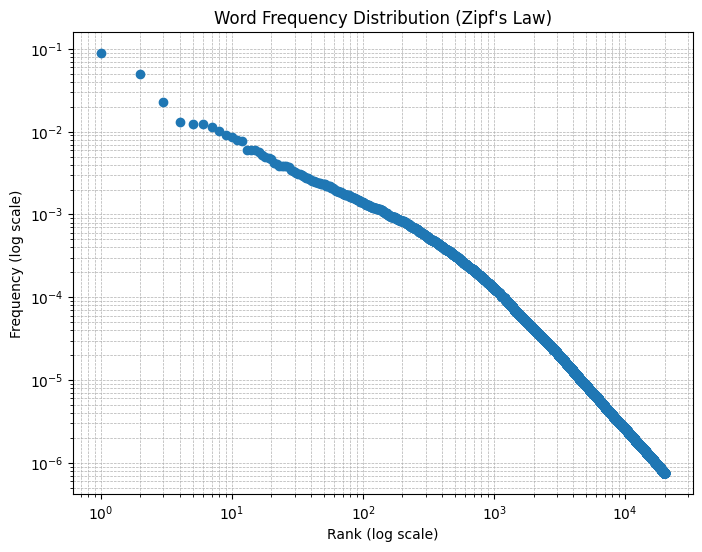

In [178]:
plt.figure(figsize=(8, 6))
# plot on a loglog graph
plt.loglog(top_20k['rank'].values, top_20k.frequency.values, marker="o", linestyle="none")

plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Word Frequency Distribution (Zipf's Law)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

We should observe a linear trend here

## normalize and skew probability scores
1.  we do not want the most frequent words to dominate (makes it too easy)

## POC

## load

In [633]:
with open("data/words.txt", "r") as f:
    words = [line.strip() for line in f][:-1]

In [639]:
words = pd.DataFrame({'word': words})

In [641]:
words["word_len"] = words.word.str.len()

In [676]:
words = words.loc[words.word_len<=5].reset_index(drop=True)

## load

In [677]:
NUM_WORDS = 10000000
raw_words = [(tup.word, tup.word_len) for tup in top_20k.itertuples()][:NUM_WORDS] # word and word_len

## preprocess

In [678]:
from numpy.random import choice
import random
from typing import Optional
from collections import namedtuple

In [679]:
def randomly_select(words:list[str], probabilities:Optional[list[float]]=None):
    selected = choice(words, 1, p=probabilities)
    if isinstance(selected, ProcessedWord):
        return selected.variation
    else:
        return selected

In [680]:
processed_words = []

ProcessedWord = namedtuple('ProcessedWord', ['variation', 'word', 'length'])

def build_possible_word_variations(word:str, word_len:int) -> list[str]:
    if word_len==3:
        return [
            f"__{word}",
            f"_{word}_",
            f"{word}__"
        ]
    elif word_len==4:
        return [
            f"{word}_",
            f"_{word}",
        ]
    elif word_len==5:
        return [word]
    else:
        ValueError("invalid word length")
    
for word, word_len in raw_words:
    possible_variations = build_possible_word_variations(word, word_len)
    for variation in possible_variations:
        processed_words.append(ProcessedWord(variation, word, word_len))

print(f"Created {len(processed_words)} variations from {len(raw_words)} words.")

Created 37903 variations from 20000 words.


In [681]:
def get_key(ch0="*", ch1="*", ch2="*", ch3="*", ch4="*"):
    return f"{ch0}{ch1}{ch2}{ch3}{ch4}"

In [682]:
from collections import defaultdict
pos_plus_char_to_word_mapping = defaultdict(set)

for tup in processed_words:
    variation, word, word_len = tup
    for item in product(["*", variation[0]], ["*", variation[1]], ["*", variation[2]], ["*", variation[3]], ["*", variation[4]]): 
        pos_plus_char_to_word_mapping[''.join(item)].add(variation) 

In [683]:
words_set = set([processed_word.variation for processed_word in processed_words])

In [684]:
def is_matchable(word):
    vowels = ('a', 'e', 'i', 'o', 'u')
    if word[1] in vowels and word[3] in vowels:
        return True
    return False

matchable_words = [processed_word.word for processed_word in processed_words if processed_word.length==5 and is_matchable(processed_word.word)]

## Step 1, start with center seed word
- center seed word has to be 5 letters long

In [685]:
# build grid
grid = [["." for _ in range(5)] for _ in range(5)]

In [686]:
def pick_a_3(grid, max_iter=MAX_ITER):
    candidate_words = matchable_words
    random.shuffle(candidate_words)
    itr = 0        
    while itr<max_iter:
        a_3 = candidate_words.pop()
        print(itr, a_3)
        for idx, ch in enumerate(a_3):
            grid[2][idx] = ch
        ans = pick_d_3(grid)
        if ans:
            return ans
        itr += 1
    return None

## Step 2: fill in the rest

In [687]:
def pick_d_3(grid, five_letters_only=True, max_iter=50):
    # pprint(grid)
    middle_letter = grid[2][2]
    possible_d_3 = [word for word in matchable_words if word[2]==middle_letter]
    if five_letters_only:
        candidate_words = [word for word in possible_d_3 if "_" not in word]
    else:
        candidate_words = possible_d_3
    random.shuffle(candidate_words)
    itr = 0        
    while candidate_words and itr<max_iter:
        d_3 = candidate_words.pop()
        for idx, ch in enumerate(d_3):
            grid[idx][2] = ch
        ans = pick_a_1(grid)
        if ans:
            return ans
        itr += 1
    return None
        

In [688]:
def pick_a_1(grid, five_letters_only=True, max_iter=50):
    # pprint(grid)
    middle_letter = grid[0][2]
    possible_a_1 = pos_plus_char_to_word_mapping[get_key(ch2=middle_letter)]
    if five_letters_only:
        candidate_words = [word for word in possible_a_1 if "_" not in word]
    else:
        candidate_words = possible_a_1
    random.shuffle(candidate_words)
    itr = 0        
    while candidate_words and itr<max_iter:
        a_1 = candidate_words.pop()
        for idx, ch in enumerate(a_1):
            grid[0][idx] = ch
        ans = pick_a_2(grid)
        if ans:
            return ans
        itr += 1

In [689]:
def pick_a_2(grid, five_letters_only=True, max_iter=50):
    # pprint(grid)
    middle_letter = grid[1][2]
    possible_a_2 = pos_plus_char_to_word_mapping[get_key(ch2=middle_letter)]
    if five_letters_only:
        candidate_words = [word for word in possible_a_2 if "_" not in word]
    else:
        candidate_words = possible_a_2
    random.shuffle(candidate_words)
    itr = 0        
    while candidate_words and itr<max_iter:
        a_2 = candidate_words.pop()
        for idx, ch in enumerate(a_2):
            grid[1][idx] = ch
        ans = pick_a_4(grid)
        if ans:
            return ans
        itr += 1

In [691]:
def get_cands(word):
    if len(word) == 4:
        return pos_plus_char_to_word_mapping[
            get_key(ch0=word[0], ch1=word[1], ch2=word[2], ch3=word[3])
        ]
    elif len(word) == 5:
        return pos_plus_char_to_word_mapping[
            get_key(ch0=word[0], ch1=word[1], ch2=word[2], ch3=word[3], ch4=word[4])
        ]
    else:
        raise ValueError(f"{word} has an unhandled length")

In [692]:
def verify_down(grid, down_len):
    d1 = ""
    for i in range(down_len):
        d1 += grid[i][0]
    cand_d1 = get_cands(d1)
    d2 = ""
    for i in range(down_len):
        d2 += grid[i][1]
    cand_d2 = get_cands(d2)
    d3 = ""
    for i in range(down_len):
        d3 += grid[i][3]
    cand_d3 = get_cands(d3)
    d4 = ""
    for i in range(down_len):
        d4 += grid[i][4]
    cand_d4 = get_cands(d4)
    if cand_d1 and cand_d2 and cand_d3 and cand_d4:
        return True
    return False
    

def pick_a_4(grid, five_letters_only=False, max_iter=100):
    # pprint(grid)
    middle_letter = grid[3][2]
    possible_a_4 = pos_plus_char_to_word_mapping[get_key(ch2=middle_letter)]
    if five_letters_only:
        candidate_words = candidate_words = [word for word in possible_a_4 if "_" not in word]
    else:
        candidate_words = list(possible_a_4)
    random.shuffle(candidate_words)
    itr = 0        
    while candidate_words and itr<max_iter:
        a_4 = candidate_words.pop()
        for idx, ch in enumerate(a_4):
            grid[3][idx] = ch
        if verify_down(grid, 4):
            ans = pick_a_5(grid)
            if ans:
                return ans
        itr += 1

def pick_a_5(grid, five_letters_only=False, max_iter=100):
    middle_letter = grid[4][2]
    possible_a_5 = pos_plus_char_to_word_mapping[get_key(ch2=middle_letter)]
    if five_letters_only:
        candidate_words = candidate_words = [word for word in possible_a_5 if "_" not in word]
    else:
        candidate_words = list(possible_a_5)
    random.shuffle(candidate_words)
    itr = 0        
    while candidate_words and itr<max_iter:
        a_5 = candidate_words.pop()
        for idx, ch in enumerate(a_5):
            grid[4][idx] = ch
        if verify_down(grid, 5):
            return grid
        itr += 1

In [693]:
def pprint(grid):
    for row in grid:
        print(row)
    print()

# test

In [671]:
# build grid
grid = [["." for _ in range(5)] for _ in range(5)]
pick_a_3(grid, max_iter=100)

0 loser
1 decor
2 satan


[['i', 's', 'l', 'a', 'm'],
 ['s', 'h', 'a', 'v', 'e'],
 ['s', 'a', 't', 'a', 'n'],
 ['_', 'm', 'e', 'n', '_'],
 ['_', 'e', 'x', 't', '_']]

In [694]:
# build grid
def find():
    start_time = time.perf_counter()
    grid = [["." for _ in range(5)] for _ in range(5)]
    grid = pick_a_3(grid, max_iter=100)
    print(f"Took {time.perf_counter()-start_time}")
    return grid

In [711]:
find()

0 livin
Took 0.04552200000034645


[['f', 'a', 'r', 'a', 'h'],
 ['a', 'r', 'e', 'n', 'a'],
 ['l', 'i', 'v', 'i', 'n'],
 ['c', 'o', 'u', '_', '_'],
 ['o', 'n', 'e', '_', '_']]

In [695]:
find()

0 doral
Took 0.4001142909983173


[['a', 'e', 'd', 's', 't'],
 ['s', 'p', 'i', 'c', 'e'],
 ['d', 'o', 'r', 'a', 'l'],
 ['_', 'c', 'a', 'l', 'i'],
 ['_', '_', 'c', 'e', 'a']]